# State reducers
- When updating same shared states in parallel, if we don't use reducers, it will throw an error as we can't update the same state simulataneously
- We need to use Annotated + reducers to do this
- e.g for a case where we add 1 to the previous node from both of it's child node, reducer would be add and we can use Annotated[list[int], add] to handle this

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import os
os.getenv('LANGCHAIN_PROJECT')

'langchain-agents-with-memory'

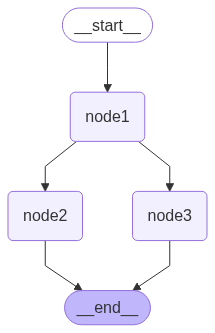

In [51]:
from operator import add
from typing import Annotated
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
# defining state
class State(BaseModel):
    foo: Annotated[list[int], add] = Field(..., description="A list of integers")
    
# build graph
def node1(state:State):
    print(f"Node 1: {state.model_dump()['foo'][-1]}")
    return {"foo":[state.model_dump()['foo'][-1] + 1]}

def node2(state:State):
    return {"foo":[state.model_dump()['foo'][-1] + 1]}

def node3(state:State):
    return {"foo":[state.model_dump()['foo'][-1] + 1]}

# build graph

builder = StateGraph(State)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

builder.add_edge(START, "node1")
builder.add_edge("node1", "node2")
builder.add_edge("node1", "node3")
builder.add_edge("node2", END)
builder.add_edge("node3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

We can see 2 and 3 update the value from node 1 in parallel

In [52]:
graph.invoke({"foo":None})

TypeError: can only concatenate list (not "NoneType") to list

# Using custom reducers
- Can use our own reducer logic to combine inputs

In [12]:
def custom_reducer(left: list| None, right: list| None) -> list:
    """
    Safely combine two lists

    Args:
        left (list | None): First list to combine or None
        right (list | None): Second list to combine or None

    Returns:
        list: A new list containing all elements from both input lists
        If an input is None, it's treated as emoty list
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

# class to use custom reducer
class CustomReducerState(BaseModel):
    foo: Annotated[list[int], custom_reducer] = Field(..., description="A list of integers")

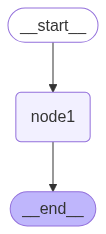

In [25]:
# buid a graph with custom reducer state:
# build graph
def node1(state:CustomReducerState):
    #print(f"Node 1: {state.model_dump()['foo'][-1]}")
    return {"foo":[state.model_dump()['foo'][-1] + 1]}

def node2(state:CustomReducerState):
    return {"foo":[state.model_dump()['foo'][-1] + 1]}

def node3(state:CustomReducerState):
    return {"foo":[state.model_dump()['foo'][-1] + 1]}

# build graph

builder = StateGraph(CustomReducerState)
builder.add_node("node1", node1)


builder.add_edge(START, "node1")
builder.add_edge("node1", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
graph.invoke({"foo":None})

IndexError: list index out of range

# Messages
- Can rewrite messages when we supply ids along with messages. We can replace message content for a particular message id
- We can overrite or remove messages using these ids

In [30]:
from langchain_core.messages import AIMessage,HumanMessage
from langgraph.graph.message import add_messages


initial_messages = [
    AIMessage(content = "Hello! How can I assist you today?", id = "1"),
    HumanMessage(content= "I am looking for a restaurant in the city", id = "2"),
]

new_message = HumanMessage(content= "I am looking for a car in the city", id = "2")
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='1'),
 HumanMessage(content='I am looking for a car in the city', additional_kwargs={}, response_metadata={}, id='2')]

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, RemoveMessage

messages = [AIMessage(content = "Hello! How can I assist you today?",name="Bot", id = "1"),
            HumanMessage(content = "I am looking for a restaurant in the city", name="User", id = "2"),
            AIMessage(content = "So you said you are looking for a restaurant in the city?", name="Bot", id = "3"),
            HumanMessage(content = "Yes, I am looking for a restaurant in the city", name="User", id = "4")]

# deleting the 2 most recent messages
deleted_messages = [RemoveMessage(id = m.id) for m in messages[-2:]]
deleted_messages

([RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='3'),
  RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='4')],
 [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
  HumanMessage(content='I am looking for a restaurant in the city', additional_kwargs={}, response_metadata={}, name='User', id='2'),
  AIMessage(content='So you said you are looking for a restaurant in the city?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
  HumanMessage(content='Yes, I am looking for a restaurant in the city', additional_kwargs={}, response_metadata={}, name='User', id='4')])

# Multiple schemas
- Typically all graph nodes communicate with a single schema
- This schema contains graph's input and output keys/channels
Sometimes we may want more control than this.
- Internal nodes can pass information that's not required by graph's input/output
- We may also want to use different input/output schemas for graph. 

# Private state
- This is useful for anything needed as part of intermediate working logic but not relevant to the overall graph input or output
- Nodes may take private state as input but write to overall graph state and vice versa

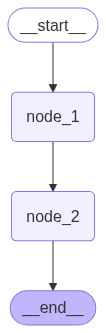

{'foo': 4}

In [33]:
from pydantic import BaseModel, Field
from typing import Annotated
from langgraph.graph import StateGraph, START, END

class OverallState(BaseModel):
    foo: int = Field(description = "An integer for overall graph state")

class PrivateState(BaseModel):
    bar: int = Field(description = "An integer for private state")
    
def node_1(state:OverallState) -> PrivateState:
    return {'bar': state.model_dump()['foo']+1}

def node_2(state:PrivateState) -> OverallState:
    return {"foo": state.model_dump()["bar"] + 1}

# build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# add edges
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# compile graph
graph = builder.compile()

# display
display(Image(graph.get_graph().draw_mermaid_png()))

# invoke:
graph.invoke({'foo':2})


## Case 2: Using specific Input and output schema
- Input schema is different from output schema

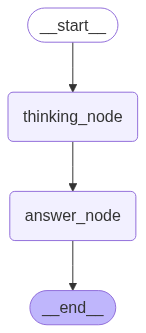

{'answer': 'Bye John Doe'}

In [35]:
class InputState(BaseModel):
    question:str = Field(description="Question asked by user")

class OutputState(BaseModel):
    answer: str = Field(description="Answer supplied by agent")

class OverallState(BaseModel):
    question:str = Field(description="Question asked by user")
    answer: str = Field(description="Answer supplied by agent")
    notes: str = Field(description="Any notes taken/supplied by agent")
    
def thinking_node(state:InputState):
    return {'question': state.model_dump()['question'],'answer': "bye", "notes": "... his name is John Doe"}

def answer_node(state:OutputState) -> OutputState:
    return {'answer': 'Bye John Doe'}

# build graph
builder = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState) # using explicit filters on what we want as the input and output states of the graph
# add nodes
builder.add_node('answer_node', answer_node)
builder.add_node('thinking_node', thinking_node)
# add edges
builder.add_edge(START, 'thinking_node')
builder.add_edge('thinking_node', 'answer_node')
builder.add_edge('answer_node', END)
# compile graph
graph = builder.compile()
# draw 
display(Image(graph.get_graph().draw_mermaid_png()))

# invoke:
graph.invoke({'question': 'Hello I am John Doe'})


# Filtering and trimming messages
- Need to use this to optimise for token usage
- Long running messages can be token intensive and have high latency if not used carefully. 
- Can use langsmith to verify what's being passed to LLMs

## Filtering messages
- Lets say we only want to keep last n messages

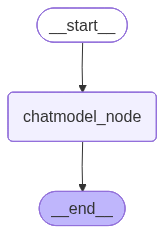

================================== Ai Message ==================================
Name: Bot

Hello! How can I assist you today?
================================ Human Message =================================
Name: User

I want to learn more about marine biology
================================== Ai Message ==================================
Name: Bot

I can help you with that. What would you like to know?
================================ Human Message =================================
Name: User

I want to know about the different types of fish in the ocean
================================ Human Message =================================

The ocean is home to a vast and diverse range of fish species, each adapted to their specific environments. Here are some broad categories and examples of different types of fish you can find in the ocean:

1. **Cartilaginous Fish (Chondrichthyes):**
   - These fish have skeletons made of cartilage rather than bone.
   - **Examples**: Sharks, rays, and

In [5]:
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph.message import MessagesState
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display



llm = ChatOpenAI(model="gpt-4o")
messages = [
    AIMessage(content = "Hello! How can I assist you today?",name="Bot"),
    HumanMessage(content = "I want to learn more about marine biology",name="User"),
    AIMessage(content = "I can help you with that. What would you like to know?",name="Bot"),
    HumanMessage(content = "I want to know about the different types of fish in the ocean",name="User"),
]

output = llm.invoke(messages)
#print(output)
# chatmodel node which only keeps latest message in history
def chatmodel_node(state:MessagesState):
    return {"messages": [llm.invoke(state['messages'][-1:])]}

# build graph
builder = StateGraph(MessagesState)
builder.add_node('chatmodel_node',chatmodel_node)
builder.add_edge(START, 'chatmodel_node')
builder.add_edge('chatmodel_node', END)
graph = builder.compile()

# display
display(Image(graph.get_graph().draw_mermaid_png()))

# append llm output to messages:
messages.append(output.content)
messages.append(HumanMessage(f"Tell me more about Whales!", name = "User"))

# look at message list
output =  graph.invoke({'messages':messages})
for m in output["messages"]:
    m.pretty_print()    

# Another approach 
- Trimming messages based on a set number of tokens
- this restricts message history to a  specified number of tokens
- While filtering only returns a post-hoc subset of messages between agents, trimming restricts the number of tokens a chat model can use to respond

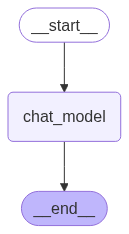

In [ ]:
from langchain_core.messages import trim_messages
# build node
def chat_model_node(state:MessagesState):
    messages = trim_messages(
        state["messages"],
        max_tokens = 100,
        strategy = "last", # starts from the most recent message in the list
        token_counter = ChatOpenAI(model="gpt-4o"),
        allow_partial=True # cut messages in the middle of them if set to True
    )
    return {"messages": [llm.invoke(messages)]}
# build graph
builder = StateGraph(MessagesState)
# add nodes
builder.add_node("chat_model", chat_model_node)
# add edges
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
# compile
graph = builder.compile()
# display
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
messages.append(output["messages"][-1])
messages.append(HumanMessage(content = "Where do Orcas live?", name="User"))

In [8]:
messages_out_trim = graph.invoke({'messages':messages})
for m in messages_out_trim["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hello! How can I assist you today?
================================ Human Message =================================
Name: User

I want to learn more about marine biology
================================== Ai Message ==================================
Name: Bot

I can help you with that. What would you like to know?
================================ Human Message =================================
Name: User

I want to know about the different types of fish in the ocean
================================ Human Message =================================

The ocean is home to a vast and diverse range of fish species, each adapted to their specific environments. Here are some broad categories and examples of different types of fish you can find in the ocean:

1. **Cartilaginous Fish (Chondrichthyes):**
   - These fish have skeletons made of cartilage rather than bone.
   - **Examples**: Sharks, rays, and